##### Tedana doens't work out-of-the-box
It cannot find any bold-like components. Two potential reasons may be:
1. The TR is too high (not enough samples to find something like a BOLD-response)
2. The SNR is too low (per voxel); with this rather high spatial resolution, the SNR is may insufficient to detect anything

1 cannot be altered, but we can try to smooth the data a bit and re-run tedana. If this doesn't work, also try to remove drifts by filtering

In [1]:
import nilearn
from nilearn import plotting, image
import nibabel as nib
import numpy as np
import os
import shutil
import tedana
import numpy
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/stevenm/miniconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable


Try sub-01, run 1.

*just* to be sure, copy these files to a new directory to prevent fuck-ups (by me)

In [2]:
run_dir = os.getcwd() + '/data/deriv/fmriprep/sub-01/ses-me/func'
fns = ['sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
       'sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
       'sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz']

In [3]:
ted_run_dir = os.path.join(os.getcwd(), 'tedana_denoising')
if not os.path.exists(ted_run_dir):
    os.mkdir(ted_run_dir)
    
# for fn in fns:
#     shutil.copy2(os.path.join(run_dir, fn), ted_run_dir)

# # also copy the accompanying mask
# mask_fn = 'sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz'
# shutil.copy2(os.path.join(run_dir, mask_fn), ted_run_dir)

In [18]:
# Smooth
echo_list = [os.path.join(ted_run_dir, fn) for fn in fns]

In [20]:
smoothed_echos = image.smooth_img(echo_list, 3.2)  # 3.2mm = 2*voxel size

In [27]:
def mean_img(hdr):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
    dat = np.mean(hdr.get_data(), 3)
    img = nib.Nifti1Image(dat, hdr.affine)
    return img

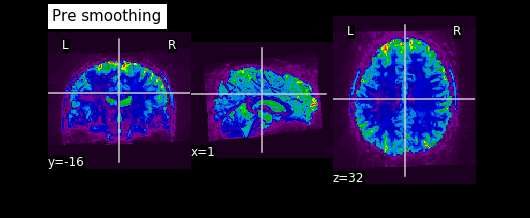

In [36]:
plotting.plot_epi(mean_img(echo_list[1]), title='Pre smoothing')

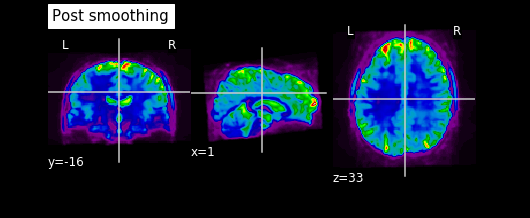

In [37]:
plotting.plot_epi(mean_img(smoothed_echos[1]), title='Post smoothing')

In [ ]:
# save smoothed data
for img, fn in zip(smoothed_echos, fns):
    nib.save(img, filename=os.path.join(ted_run_dir, fn.replace('.nii.gz', '_fwhm32.nii.gz')))

### Run tedana

In [1]:
!ls tedana_denoising/

sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz
sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz
sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz
sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz
sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz


In [6]:
## Set filenames, tes, get mask
fns_ted = [os.path.join(ted_run_dir, 'sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz'),
           os.path.join(ted_run_dir, 'sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz'),
           os.path.join(ted_run_dir, 'sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz')]
tes = 9.66, 24.87, 40.08  # in ms
mask = os.path.join(ted_run_dir, 'sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz')

In [6]:
from tedana.workflows import tedana_workflow

In [12]:
os.chdir(ted_run_dir)  # tedana has some annoying ways of going about with working directories...
tedana_workflow(data=fns_ted, tes=tes, mask=mask)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/model/fit.py:161: RuntimeWarning: divide by zero encountered in true_divide
  F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq

In [14]:
## plot tSNR?
def tsnr_img(hdr):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
        
    dat = hdr.get_data()
    mn = np.mean(dat, 3)
    sd = np.std(dat, 3)
    
    img = nib.Nifti1Image(mn/sd, hdr.affine)
    return img

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


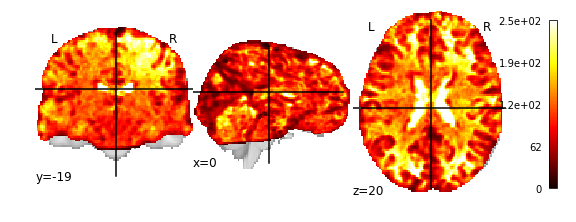

In [16]:
plotting.plot_stat_map(tsnr_img('./dn_ts_OC.nii'), vmax=250)

###### The above seems to have worked. Let's loop and see if it also works for other subjects & runs

In [ ]:
from tedana.workflows import tedana_workflow
highpassed = True

for sub in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '13', '14', '15', '16', '17', '18']:
    for run in [1, 2, 3]:
        print('Processing sub %s run %d' %(sub, run))
        os.chdir(ted_run_dir)

        run_dir = os.getcwd() + '/../data/deriv/fmriprep/sub-%s/ses-me/func' %sub
        fns_orig = ['sub-%s_ses-me_task-stop_run-%d_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, run),
                    'sub-%s_ses-me_task-stop_run-%d_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, run),
                    'sub-%s_ses-me_task-stop_run-%d_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'%(sub, run)]
        if highpassed:
            fns_orig = [x.replace('.nii.gz', '_hp.nii.gz') for x in fns_orig]
        
        if os.path.exists(os.path.join(ted_run_dir, 'TED.'+fns_orig[0].replace('.nii.gz', '_fwhm32'))):
            print('Already processed, continueing...')
            continue

        # copy the files, to be sure
        for fn in fns_orig:
            if not os.path.exists(os.path.join(ted_run_dir, fn)):
                shutil.copy2(os.path.join(run_dir, fn), ted_run_dir)

        # also copy the accompanying mask
        mask_fn = 'sub-%s_ses-me_task-stop_run-%d_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz'%(sub, run)
        shutil.copy2(os.path.join(run_dir, mask_fn), ted_run_dir)

        # check if smoothing is already done
        fns_ted = [os.path.join(ted_run_dir, 'sub-%s_ses-me_task-stop_run-%d_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz'%(sub, run)),
                   os.path.join(ted_run_dir, 'sub-%s_ses-me_task-stop_run-%d_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz'%(sub, run)),
                   os.path.join(ted_run_dir, 'sub-%s_ses-me_task-stop_run-%d_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_fwhm32.nii.gz'%(sub, run))]
        if highpassed:
            fns_ted = [x.replace('_fwhm32.nii.gz', '_hp_fwhm32.nii.gz') for x in fns_ted]

        for smoothed_fn, orig_fn in zip(fns_ted, [os.path.join(ted_run_dir, fn) for fn in fns_orig]):
            if not os.path.exists(smoothed_fn):
                print('%s doesnt exit yet; smoothing...' %smoothed_fn)
                smoothed_img = image.smooth_img(orig_fn, 3.2)
                nib.save(smoothed_img, smoothed_fn)

        # Set tes, get mask fn
        tes = 9.66, 24.87, 40.08  # in ms
        mask = os.path.join(ted_run_dir, 'sub-%s_ses-me_task-stop_run-%d_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz'%(sub, run))

        os.chdir(ted_run_dir)  # tedana has some annoying ways of going about with changing working directories...
        tedana_workflow(data=fns_ted, tes=tes, mask=mask)
        
        os.chdir(ted_run_dir)
        #clean-up: remove unsmoothed data, smoothed data, brain mask
        for fn in fns_orig:
            os.remove(os.path.join(ted_run_dir, fn))
        for fn in fns_ted:
            os.remove(fn)
        os.remove(mask)

Processing sub 01 run 1
/home/stevenm/MultiEchoEPISeq/tedana_denoising/sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32.nii.gz doesnt exit yet; smoothing...
/home/stevenm/MultiEchoEPISeq/tedana_denoising/sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32.nii.gz doesnt exit yet; smoothing...
/home/stevenm/MultiEchoEPISeq/tedana_denoising/sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp_fwhm32.nii.gz doesnt exit yet; smoothing...


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/combine.py:35: RuntimeWarning: divide by zero encountered in true_divide
  alpha = tes * np.exp(-tes / ft2s)
/home/stevenm/miniconda3/lib/python3.7/site-packages/tedana/model/fit.py:167: RuntimeWarning: divide by zero encountered in true_divide
  F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)
/home/stevenm/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWa